In [11]:
import numpy as np
import librosa
from scipy.io.wavfile import read, write
from matplotlib import pyplot as plt
import scipy.ndimage
import IPython.display as display
from tqdm import tqdm

In [2]:
# !wget http://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [3]:
audio, rate = librosa.load('./vikanikita.wav')

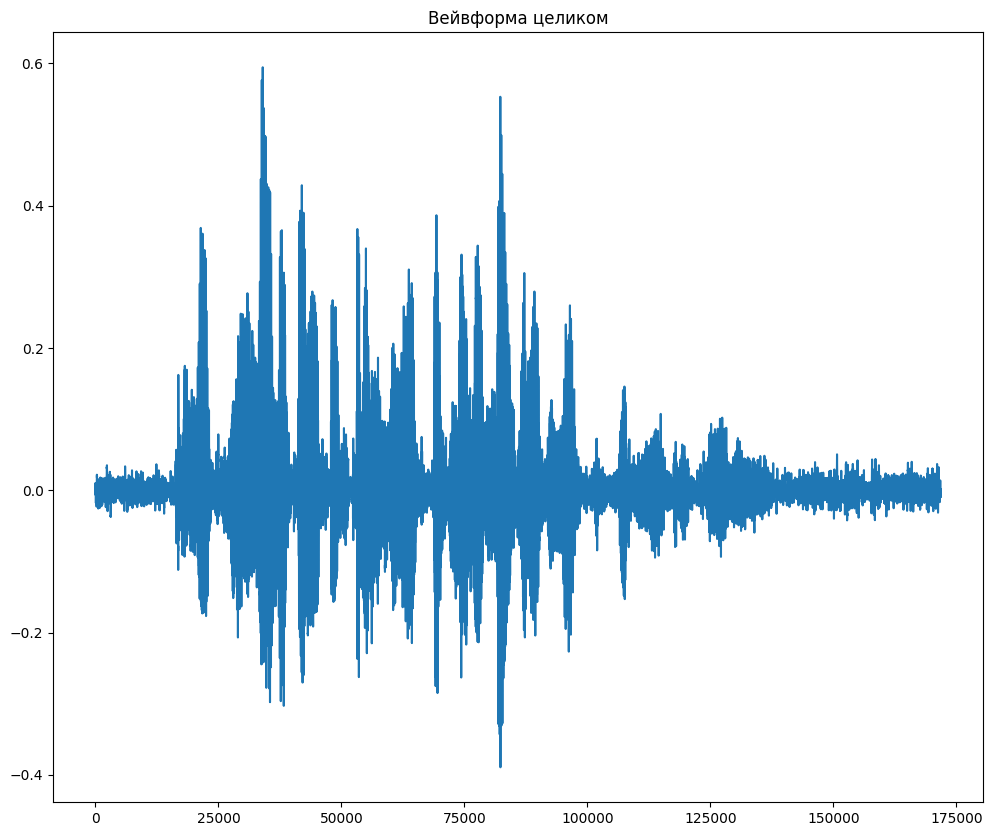

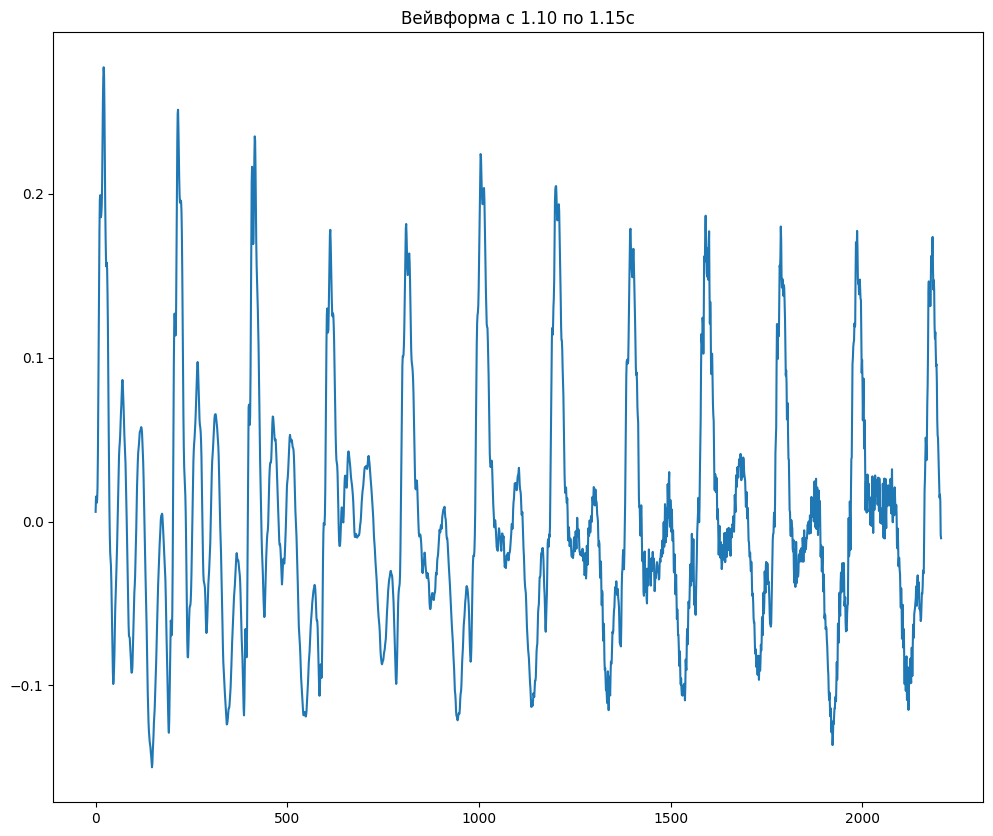

In [4]:
plt.figure(figsize=(12, 10))
plt.title('Вейвформа целиком')
plt.plot(audio)

plt.figure(figsize=(12, 10))
plt.title('Вейвформа с 1.10 по 1.15с')
plt.plot(audio[int(rate*1.4):int(rate*1.5)])

In [5]:
print(rate)

def resample(audio, scale=2):
    subscaled = audio[::scale]
    return scipy.ndimage.zoom(subscaled, scale)

22050


In [6]:
display.Audio(audio, rate=rate)

In [7]:
audio_12khz = resample(audio, 2)
audio_6000hz = resample(audio, 4)
audio_3000hz = resample(audio, 8)
audio_1500hz = resample(audio, 16)
audio_375hz = resample(audio, 64)

In [10]:
display.Audio(audio_3000hz, rate=rate)

### time-frequency domain

(171873,)
(1025, 336)
[[-1.4499808e-05+0.00000000e+00j -6.3734606e-06+0.00000000e+00j
   5.7754926e-07+0.00000000e+00j ... -3.7602999e-07+0.00000000e+00j
  -1.4427500e-06+0.00000000e+00j -1.1124437e-05+0.00000000e+00j]
 [ 1.1655545e-05-3.32536615e-06j  1.3571552e-06+1.36696872e-05j
   2.8678405e-06-5.95299070e-06j ... -9.5018788e-07+1.62627373e-07j
  -2.4882243e-06+5.36540654e-07j  7.0787992e-06-1.11757145e-05j]
 [-1.5565494e-05+2.88134743e-06j -1.0782412e-05+2.98502001e-09j
   1.4139718e-05+3.87305372e-05j ...  1.4349735e-05+1.18274775e-05j
   3.9830993e-06-1.78553491e-05j -1.1276400e-05+7.15771375e-06j]
 ...
 [ 8.9180254e-08-4.63396155e-10j -4.4474568e-08+2.31516542e-10j
  -2.6628019e-14-8.09562974e-13j ...  2.2819862e-12+6.31895849e-13j
   1.5213319e-10-2.24542177e-10j -1.9612940e-09+2.85250201e-09j]
 [-8.9179927e-08+2.32203812e-10j  1.1677882e-10+4.44748025e-08j
   1.7545081e-12+2.81629321e-13j ... -1.6474180e-12-3.97228095e-13j
   2.4113675e-10-1.25204236e-10j -1.6110814e-09-3.064

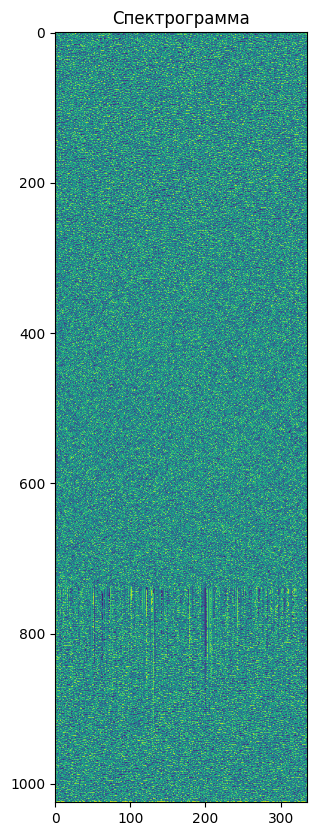

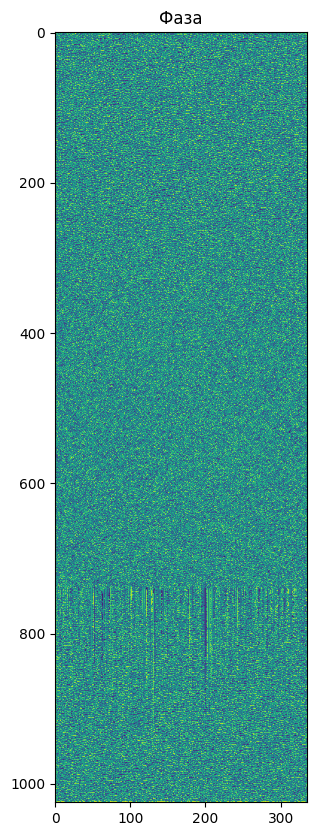

In [14]:
print(audio.shape)
stft = librosa.core.stft(audio / 2**15)  # audio samples in [-1, 1]
print(stft.shape)
print(stft)
print(stft.shape[0] * stft.shape[1])

spectrogram = np.abs(stft)
phase = np.angle(stft)
print(spectrogram.shape, phase.shape)

plt.figure(figsize=(40, 10))
plt.title('Спектрограмма')
plt.imshow(np.log(1.e-8 + spectrogram)[::-1])  # логарифм для красоты
plt.imshow(np.log(1.e-8 + librosa.feature.melspectrogram(y=audio / 2**15)))
plt.imshow(phase)

plt.figure(figsize=(12, 10))
plt.title('Фаза')
plt.imshow(phase)

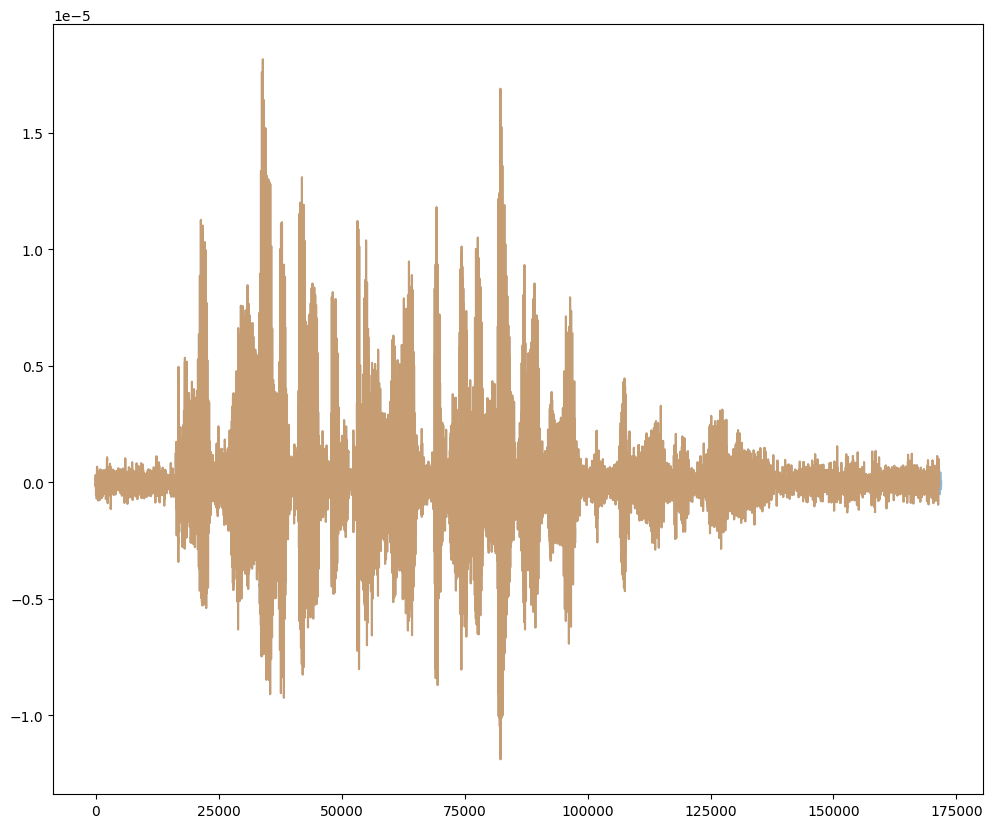

In [15]:
restored_audio = librosa.core.istft(spectrogram * np.exp(1j * phase))

plt.figure(figsize=(12,10))
plt.plot(audio / 2**15, alpha=0.5)
plt.plot(restored_audio, alpha=0.5)

In [64]:
def griffin_lim(spectrogram, window_size=2048, hop_length=512, iterations=1, verbose=True):
    time_slices = spectrogram.shape[1]
    len_samples = int(time_slices*hop_length-hop_length)
    magnitude_spectrogram = np.abs(spectrogram)
    x_reconstruct = np.random.randn(len_samples)
    for n in range(iterations):
        reconstruction_spectrogram = librosa.core.stft(x_reconstruct)
        reconstruction_angle = np.angle(reconstruction_spectrogram)
        proposal_spectrogram = np.exp(1j*reconstruction_angle) *  magnitude_spectrogram
        
        prev_x = x_reconstruct
        
        x_reconstruct = librosa.core.istft(proposal_spectrogram)
        
        print(x_reconstruct.size, prev_x.size)
        
        diff = np.sqrt(sum((x_reconstruct - prev_x)**2)/x_reconstruct.size)
        if verbose:
            print('Reconstruction iteration: {}/{} RMSE: {} '.format(n, iterations, diff))
    return x_reconstruct

In [65]:
audio_iter1 = griffin_lim(spectrogram, iterations=1)
display.Audio(audio_iter1, rate=rate)

171520 171520
Reconstruction iteration: 0/1 RMSE: 0.997498350645232 


In [72]:
def griffin_lim(spectrogram, iterations=10):
    eps = 1e-6
    phase = 2 * np.pi * np.random.uniform(size=spectrogram.shape)
    restored = spectrogram * np.exp(1j * phase)
    for iteration in tqdm(range(iterations)):
        prev_rest = restored
        inversed = librosa.istft(restored, n_fft=2048)
        rebuilt = librosa.stft(inversed, n_fft=2048)
        restored = spectrogram * rebuilt / (np.abs(rebuilt) + eps)
        print(librosa.istft(restored).size, librosa.istft(prev_rest).size)
        
        nmse = np.sqrt(sum((librosa.istft(restored) - librosa.istft(prev_rest))**2) / librosa.istft(restored).size)
        print(f"iteration: {iteration}, MSE: {nmse}")
        
        # restored = librosa.istft(restored)
    return librosa.istft(restored)
    # return restored

In [73]:
audio_iter1 = griffin_lim(spectrogram, iterations=1)
display.Audio(audio_iter1, rate=rate)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 13.01it/s]

171520 171520
iteration: 0, MSE: 8.277356775090945e-07


In [40]:
def griffin_lim(spectrogram, window_size=2048, hop_length=512, iterations=1, verbose=True):
    time_slices = spectrogram.shape[1]
    len_samples = int(time_slices*hop_length-hop_length)
    magnitude_spectrogram = np.abs(spectrogram)
    x_reconstruct = np.random.randn(len_samples)
    for n in range(iterations):
        reconstruction_spectrogram = librosa.core.stft(x_reconstruct)
        reconstruction_angle = np.angle(reconstruction_spectrogram)
        proposal_spectrogram = np.exp(1j*reconstruction_angle) *  magnitude_spectrogram
        
        prev_x = x_reconstruct
        
        x_reconstruct = librosa.core.istft(proposal_spectrogram)
        
        print(x_reconstruct.size, prev_x.size)
        
        diff = np.sqrt(sum((x_reconstruct - prev_x)**2)/x_reconstruct.size)
        if verbose:
            print('Reconstruction iteration: {}/{} RMSE: {} '.format(n, iterations, diff))
    return x_reconstruct

In [41]:
audio_iter1 = griffin_lim(spectrogram, iterations=1)
display.Audio(audio_iter1, rate=rate)

171520 171520
Reconstruction iteration: 0/1 RMSE: 1.001615440126367 


In [12]:
audio_iter10 = griffin_lim(spectrogram, iterations=10)
display.Audio(audio_iter10, rate=rate)

Reconstruction iteration: 0/10 RMSE: 1.0010035027338948 
Reconstruction iteration: 1/10 RMSE: 3.5995897412391667e-07 
Reconstruction iteration: 2/10 RMSE: 2.053966096447907e-07 
Reconstruction iteration: 3/10 RMSE: 1.4758728351798342e-07 
Reconstruction iteration: 4/10 RMSE: 1.1455507749158418e-07 
Reconstruction iteration: 5/10 RMSE: 9.841231515943053e-08 
Reconstruction iteration: 6/10 RMSE: 8.892054708771872e-08 
Reconstruction iteration: 7/10 RMSE: 8.251790370823093e-08 
Reconstruction iteration: 8/10 RMSE: 7.707116240888326e-08 
Reconstruction iteration: 9/10 RMSE: 7.251992857914935e-08 


In [13]:
audio_iter100 = griffin_lim(spectrogram, iterations=100)
display.Audio(audio_iter100, rate=rate)

Reconstruction iteration: 0/100 RMSE: 0.9961540217587683 
Reconstruction iteration: 1/100 RMSE: 3.4005034885917423e-07 
Reconstruction iteration: 2/100 RMSE: 1.961643085549218e-07 
Reconstruction iteration: 3/100 RMSE: 1.4963434808540752e-07 
Reconstruction iteration: 4/100 RMSE: 1.2578002553873155e-07 
Reconstruction iteration: 5/100 RMSE: 1.0976645853218703e-07 
Reconstruction iteration: 6/100 RMSE: 9.706773432245637e-08 
Reconstruction iteration: 7/100 RMSE: 8.751242393472932e-08 
Reconstruction iteration: 8/100 RMSE: 8.023373639529124e-08 
Reconstruction iteration: 9/100 RMSE: 7.547314473668479e-08 
Reconstruction iteration: 10/100 RMSE: 7.100131731115271e-08 
Reconstruction iteration: 11/100 RMSE: 6.567385641743732e-08 
Reconstruction iteration: 12/100 RMSE: 6.045245520862048e-08 
Reconstruction iteration: 13/100 RMSE: 5.610634855962211e-08 
Reconstruction iteration: 14/100 RMSE: 5.294059220727712e-08 
Reconstruction iteration: 15/100 RMSE: 5.075081485499771e-08 
Reconstruction it

In [14]:
mel_spectrogram = librosa.feature.melspectrogram(audio)

restored_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram)
print(restored_spectrogram.shape)

plt.figure(figsize=(12, 10))
plt.title('Предсказанная спектрограмма')
plt.imshow(np.log(1.e-8 + restored_spectrogram))
plt.figure(figsize=(12, 10))
plt.title('Настоящая спектрограмма')
plt.imshow(np.log(1.e-8 + spectrogram))

TypeError: melspectrogram() takes 0 positional arguments but 1 was given

In [ ]:
restored_audio = griffin_lim(restored_spectrogram, iterations=100)
display.Audio(restored_audio, rate=rate)

NameError: name 'griffin_lim' is not defined